Basierend auf unserer fachlichen Expertise und der explorativen Datenanalyse (EDA) könnten folgende Variablen relevant sein, um den Preis einer Immobilie vorherzusagen:

1. Standortbezogene Variablen
   - distanceToCenter: Entfernung zum Zentrum
   - northeast, northwest, southeast, southwest: Spezifische Standorte

2. Grundlegende Eigenschaften
   - constructionYear: Baujahr des Objekts
   - livingSpace: Wohnfläche in Quadratmetern (auch log_livingspace wird berücksichtigt)
   
3. Energie und Nachhaltigkeit
   - energyClass: Energieeffizienzklasse
   - energySources: Energieträger des Objekts **(entfernt - statisch nicht signifikant)**

4. Komfort und Ausstattung
   - elevator: Vorhandensein eines Aufzugs
   - sauna: Vorhandensein einer Sauna
   - swimmingpool: Vorhandensein eines Swimmingpools
   - kitchenEquipped: Ausgestattete Küche
   - cellar: Vorhandensein eines Kellers
   - storageRoom: Abstellraum

5. Zugänglichkeit und zusätzliche Merkmale
   - wheelchairAccessible: Barrierefreiheit
   - assistedLiving: Betreutes Wohnen

6. Außenbereich und Extras
   - parkingSlots: Parkplätze
   - privateOutdoorSpace: Privater Außenbereich
   - chimney: Kamin
   - cuestToilet: Gäste-WC
   - attics: Wohnung im Dachgeschoss

7. Zielvariable
   - price und log_price: Preis des Objekts (Predictor)

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import ast

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns  

# seaborn settings
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

import altair as alt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
filePath = r'https://raw.githubusercontent.com/hdm-statistik-lpj/project/main/data/external/immobilienNuernberg_cleaned.csv'
df = pd.read_csv(filePath)

In [3]:
df.columns

Index(['location', 'Northeast', 'Northwest', 'Southeast', 'Southwest',
       'energyEfficiency', 'price', 'constructionYear', 'livingSpace',
       'energySources', 'photosCount', 'localAmenitiesScore',
       'localMobilityScore', 'latitudeDistrict', 'longitudeDistrict',
       'distanceToCenter', 'district', 'rooms', 'energyClass', 'elevator',
       'sauna', 'swimmingpool', 'kitchenEqipped', 'cellar', 'storageRoom',
       'wheelchairAccessible', 'assistedLiving', 'parkingSlots', 'guestToilet',
       'privateOutdoorSpace', 'chimney', 'attics'],
      dtype='object')

In [4]:
# Nummerische Variablen
df['constructionYear'] = df['constructionYear'].astype(int)
df['livingSpace'] = df['livingSpace'].astype(float)
df['photosCount'] = df['photosCount'].astype(int)
df['localAmenitiesScore'] = df['localAmenitiesScore'].astype(float)
df['localMobilityScore'] = df['localMobilityScore'].astype(float)
df['latitudeDistrict'] = df['latitudeDistrict'].astype(float)
df['longitudeDistrict'] = df['longitudeDistrict'].astype(float)
df['distanceToCenter'] = df['distanceToCenter'].astype(float)
df['price'] = df['price'].astype(float)
df['rooms'] = df['rooms'].astype(float)

# Kategorische Variablen
df['district'] = df['district'].astype('category')
df['location'] = df['location'].astype('category')
df['energyClass'] = df['energyClass'].astype('category')
df['energySources'] = df['energySources'].astype('category')

# Binäre Variablen
binaryColumns = ['elevator', 'sauna', 'swimmingpool', 'kitchenEqipped', 
                  'cellar', 'storageRoom', 'wheelchairAccessible', 'assistedLiving', 
                  'parkingSlots', 'guestToilet', 'privateOutdoorSpace', 
                  'chimney', 'attics', 'energyEfficiency', 
                  'Northeast', 'Northwest', 'Southeast', 'Southwest']

for col in binaryColumns:
    df[col] = df[col].astype('category')

In [5]:
# Modell 1: 'price' als abhängige Variable
X_price = df.drop('price', axis=1)
y_price = df['price']
X_price['log_livingSpace'] = np.log(X_price['livingSpace'])

In [6]:
# Aufteilen der Daten für das Modell mit 'price' als abhängige Variable
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
    X_price, y_price, test_size=0.2, random_state=42, stratify=df['energyClass'])
df_train_price = pd.concat([X_train_price, y_train_price], axis=1)
df_test_price = pd.concat([X_test_price, y_test_price], axis=1)

In [7]:
df_train_price['log_price'] = np.log(df_train_price['price'])

In [8]:
# Formula 
formula = 'np.log(price) ~ log_livingSpace + location + constructionYear + energyClass + sauna + kitchenEqipped + cellar'

# Fit 
model = smf.ols(formula=formula, data=df_train_price).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     164.0
Date:                Tue, 26 Dec 2023   Prob (F-statistic):          2.75e-181
Time:                        23:19:42   Log-Likelihood:                 112.34
No. Observations:                 490   AIC:                            -190.7
Df Residuals:                     473   BIC:                            -119.4
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.4496    

#### Überprüfen der Gesamtbedeutung der kategorialen Variablen 'location' und 'energyClass'

In [9]:
# Formula
formula = 'np.log(price) ~ C(location) + C(energyClass) + log_livingSpace + constructionYear + sauna + kitchenEqipped + cellar'

# Fit
model = smf.ols(formula=formula, data=df_train_price).fit()

# F-test für 'location'
hypotheses = '(C(location)[T.2] = C(location)[T.3] = C(location)[T.4] = 0)'

model.f_test(hypotheses)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=15.534851036405037, p=1.1842492287412158e-09, df_denom=473, df_num=3>

Das Ergebnis zeigt, dass die kategoriale Variable 'location' einen statistisch signifikanten Einfluss auf den logarithmierten Preis hat.

In [10]:
hypotheses = 'C(energyClass)[T.2] = C(energyClass)[T.3] = C(energyClass)[T.4] = C(energyClass)[T.5] = C(energyClass)[T.6] = C(energyClass)[T.7] = C(energyClass)[T.8] = C(energyClass)[T.9] = 0'

model.f_test(hypotheses)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=21.70761445795818, p=3.435955410118362e-28, df_denom=473, df_num=8>

Das Ergebnis zeigt, dass die kategoriale Variable 'energyClass' einen statistisch signifikanten Einfluss auf den logarithmierten Preis hat.

#### Zusammenfassung von Regressionskoeffizienten für Immobilienpreisfaktoren
- **log_livingSpace:** Ein positiver und statistisch signifikanter Koeffizient zeigt, dass eine Zunahme der logarithmierten Wohnfläche mit höheren logarithmierten Preisen einhergeht. Dies bestätigt unsere ursprüngliche Hypothese.

- **constructionYear:** Ein positiver und statistisch signifikanter Koeffizient zeigt, dass neuere Immobilien tendenziell höhere Preise erzielen. Das Ergebnis bestätigt unsere ursprüngliche Hypothese.

- **location:** Verschiedene Standorte (zwei bis vier) haben im Vergleich zum Referenzstandort niedrigere Preise. Das Ergebnis der F-Statistic zeigt, dass die kategoriale Variable 'location' einen statistisch signifikanten Einfluss auf den logarithmierten Preis hat. Dies bestätigt unsere ursprüngliche Hypothese, dass Preise je nach Standort variieren.

- **energyClass:** Alle Koeffizienten für verschiedene Energieklassen sind negativ. Jedoch ist zu beobachten, dass Immobilien mit niedrigeren Energieeffizienzklassen tendenziell günstiger sind. Das Ergebnis der F-Statistic zeigt, dass die kategoriale Variable 'energyClass' einen statistisch signifikanten Einfluss auf den logarithmierten Preis hat. Dies bestätigt unsere ursprüngliche Hypothese, dass Immobilien mit besserer Energieeffizienz zu höheren Preisen angeboten werden.

- **sauna, kitchenEquipped, cellar:** Positive Koeffizienten zeigen, dass das Vorhandensein einer Sauna, einer ausgestatteten Küche und eines Kellers mit höheren Immobilienpreisen verbunden ist.

#### Interpretation der Koeffizienten

- **log_livingSpace:** Eine 1%ige Erhöhung der Wohnfläche ist mit einer Erhöhung des Preises um ungefähr 0.9763% verbunden, unter der Annahme, dass alle anderen Variablen konstant bleiben.

- **constructionYear:** Mit jedem zusätzlichen Jahr im Baujahr (neuere Immobilien) ist mit einer geringen prozentualen Erhöhung des Preises verbunden.

- **location:** Immobilien in diesen Standortkategorien (zwei bis vier) haben im Vergleich zur Referenzkategorie geringere Preise, ausgedrückt in Prozent.

- **energyClass:** Die negativen Koeffizienten für verschiedene Energieklassen deuten darauf hin, dass Immobilien mit niedrigeren Energieeffizienzklassen im Vergleich zur Referenzkategorie niedrigere Preise haben, ebenfalls in prozentualen Werten ausgedrückt.

- **sauna, kitchenEqipped, cellar:** Die positiven Koeffizienten zeigen, dass das Vorhandensein einer Sauna, einer ausgestatteten Küche und eines Kellers mit einer prozentualen Erhöhung des Preises verbunden ist.


#### Statistiken

- **Bestimmtheitsmaß:** Mit einem Wert von 0.847 erklärt das Modell einen großen Teil der Varianz im logarithmierten Preis. Dies deutet darauf hin, dass das Modell gut an die Trainings-Daten angepasst ist.

- **F-Statistik:** Die signifikante F-Statistik zeigt an, dass das Modell insgesamt statistisch signifikant ist.

- **Omnibus, Skew, Kurtosis, Jarque-Bera:** Die statistischen Tests zur Normalverteilung der Residuen deuten darauf hin, dass die Residuen wahrscheinlich normalverteilt sind.

- **Durbin-Watson:** Der Wert von 2.082 liegt sehr nahe an zwei, was darauf hindeutet, dass Autokorrelation kein Problem ist.

- **Cond. No. (Condition Number)** Die hohe Konditionszahl könnte auf Multikollinearität hinweisen.

### Validierung auf dem Testdatensatz

In [11]:
# formula 
formula = 'np.log(price) ~ log_livingSpace + location + constructionYear + energyClass + sauna + kitchenEqipped + cellar'

# Fit 
model1 = smf.ols(formula=formula, data=df_test_price).fit()

# summary
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     58.58
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           1.74e-44
Time:                        23:19:42   Log-Likelihood:                 34.878
No. Observations:                 123   AIC:                            -37.76
Df Residuals:                     107   BIC:                             7.238
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.2999    

Das Modell weist auch auf dem Test-Datensatz einen hohen R-squared und Adjusted R-squared auf und ist insgesamt signifikant. Dies deutet auf eine gute Anpassung des Modells hin.

#### Partial Regression Plots für die kontinuierlichen unabhängigen Variablen (log_livingSpace und constructionYear)

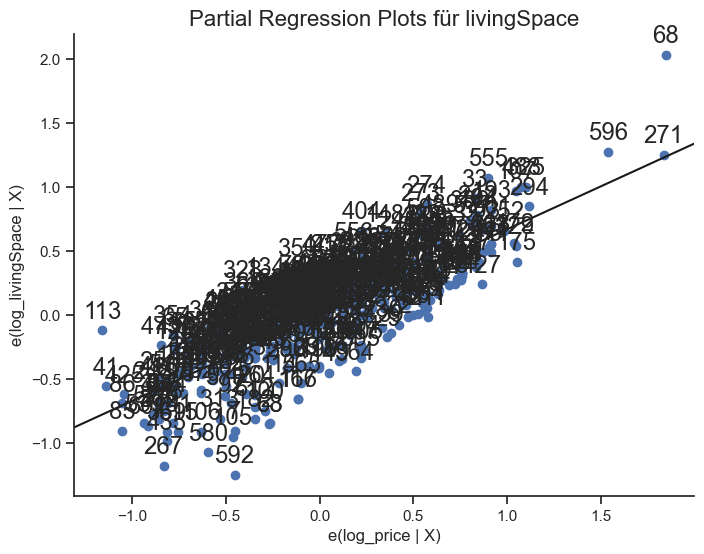

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
sm.graphics.plot_partregress('log_livingSpace', 'log_price', exog_others=[], data=df_train_price, ax=ax)
ax.set_title("Partial Regression Plots für livingSpace", fontsize=16)
plt.show()

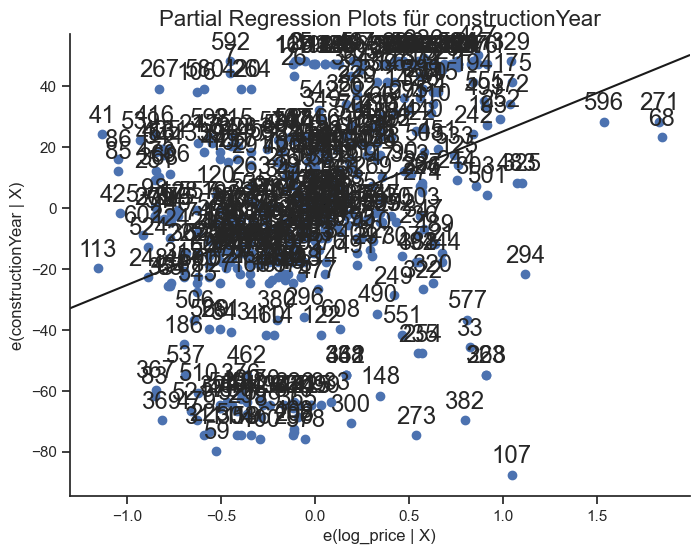

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
sm.graphics.plot_partregress('constructionYear', 'log_price', exog_others=[], data=df_train_price, ax=ax)
ax.set_title("Partial Regression Plots für constructionYear", fontsize=16)
plt.show()

- **log_livingSpace:** Die Partial Regression zeigt eine klare positive Beziehung zwischen der logarithmierten Wohnfläche und der abhängigen Variable.

- **constructionYear:** Auch hier ist eine positive Beziehung erkennbar, jedoch weniger ausgeprägt als bei log_livingSpace.

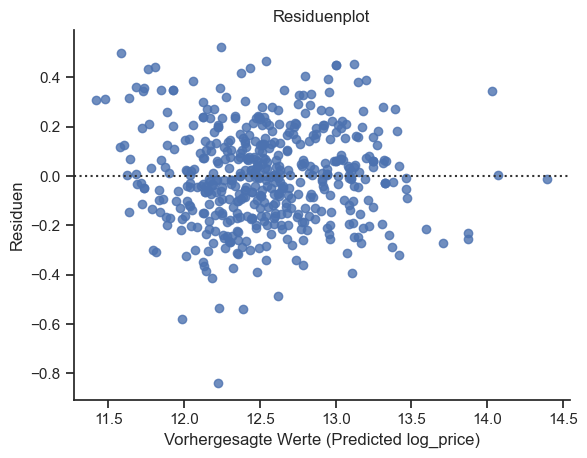

In [14]:
# Berechnung der Residuen
residuals = model.resid

# Residuenplot
sns.residplot(x=model.fittedvalues, y=residuals)

# Beschriftungen und Titel des Plots festlegen
plt.xlabel('Vorhergesagte Werte (Predicted log_price)')
plt.ylabel('Residuen')
plt.title('Residuenplot')

# Show the plot
plt.show()

Der Residuenplot zeigt eine zufällige Verteilung der Residuen. Das Modell beschreibt die Daten angemessen.

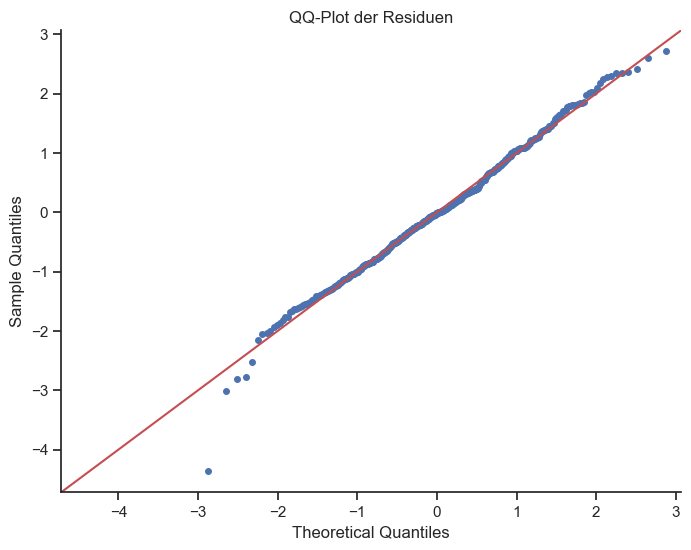

In [15]:
# Berechnung der quantilen Residuen
residuals = model.resid
residuals_quantiles = sm.ProbPlot(residuals, fit=True)

# QQ-Plot erstellen
fig, ax = plt.subplots(figsize=(8, 6))
residuals_quantiles.qqplot(line='45', ax=ax, markersize=4)
ax.set_title('QQ-Plot der Residuen')
plt.show()

Die Verteilung der Residuen folgen tendenziell einer Normalverteilung. Die Abweichungen an den Enden könnten auf das Vorhandensein von Ausreißern hindeuten.

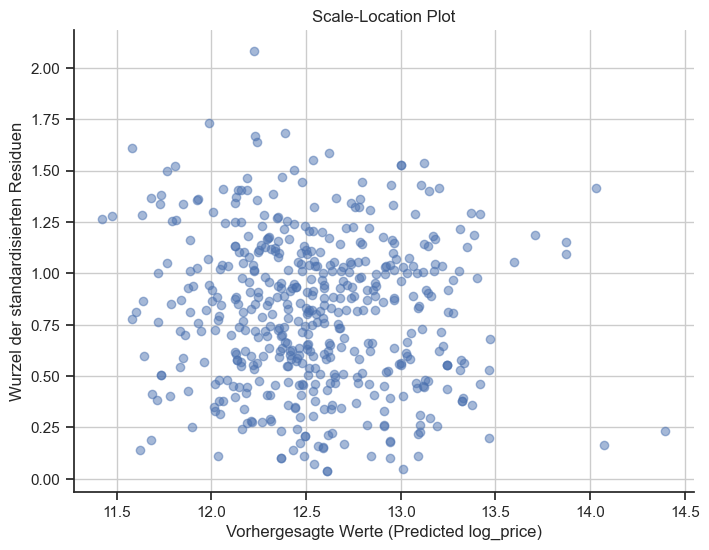

In [16]:
# Berechnung der standardisierten Residuen
residuals = model.get_influence().resid_studentized_internal

# Berechnung der Wurzel der standardisierten Residuen
sqrt_abs_residuals = np.sqrt(np.abs(residuals))

# Plot erstellen
plt.figure(figsize=(8, 6))
plt.scatter(model.fittedvalues, sqrt_abs_residuals, alpha=0.5)
plt.xlabel('Vorhergesagte Werte (Predicted log_price)')
plt.ylabel('Wurzel der standardisierten Residuen')
plt.title('Scale-Location Plot')
plt.grid(True)
plt.show()

Es ist kein Muster erkennbar. Die Varianz der Residuen ist über den Bereich der angepassten Werte hinweg relativ konstant. Dies deutet auf Homoskedastizität hin.

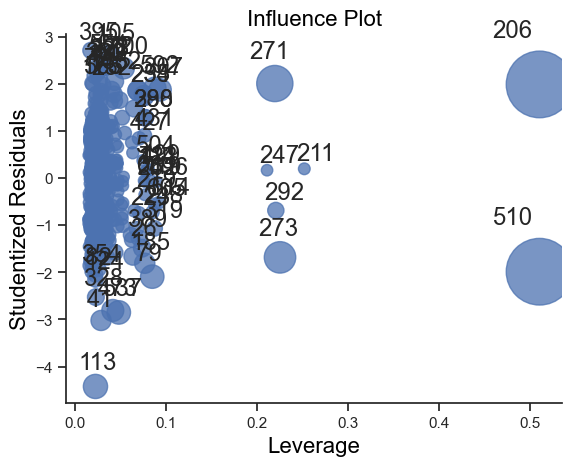

In [17]:
sm.graphics.influence_plot(model, criterion="cooks")
fig.tight_layout(pad=7.0)

Während die meisten Datenpunkte in der Nähe des Zentrums liegen, gibt es einige Beobachtungen mit höherer Hebelwirkung (Leverage) und hohen Residuen. Diese Punkte könnten potenzielle Ausreißer sein.

In [18]:
# Cook's Distanz berechnen 
model_cooksd = model.get_influence().cooks_distance[0]

# Die Anzahl der Datenpunkte (n) bestimmen
n = len(df_train_price["price"])

# Kritische Distanz berechnen
critical_d = 4/n
print('Kritische Cooks Distanz:', critical_d)

# Identifikation potenzieller Ausreißer anhand der Hebelwirkung
out_d = model_cooksd > critical_d

# Potenzielle Ausreißer mit Hebelwirkung ausgeben
print(df_train_price.index[out_d], "\n", 
    model_cooksd[out_d])

Kritische Cooks Distanz: 0.00816326530612245
Index([579, 268, 473, 551, 273, 172, 185, 328, 107, 254,  26, 244, 307,  79,
       220, 100, 105, 271, 592, 113,  58, 537,  41, 510, 382,  63, 206, 235,
       323, 580],
      dtype='int64') 
 [0.00870763 0.0098991  0.01997766 0.00970529 0.04827284 0.01130909
 0.01592533 0.00883423 0.00890933 0.01487479 0.01041128 0.00836161
 0.0212013  0.02378532 0.01099677 0.01801064 0.01606887 0.06622653
 0.02055515 0.02584234 0.01496531 0.02395095 0.01572479 0.24062607
 0.01125922 0.01500059 0.24062607 0.01482288 0.0098991  0.00833453]


In [19]:
df_train_price.loc[out_d]

,location,Northeast,Northwest,Southeast,Southwest,energyEfficiency,constructionYear,livingSpace,energySources,photosCount,...,wheelchairAccessible,assistedLiving,parkingSlots,guestToilet,privateOutdoorSpace,chimney,attics,log_livingSpace,price,log_price
579,4,0,0,0,1,0,1909,37.00,4.0,8,...,0,0,0,0,1,0,0,3.610918,169000.0,12.037654
268,1,1,0,0,0,0,1920,122.00,1.0,12,...,0,0,0,0,1,0,0,4.804021,696000.0,13.453105
473,4,0,0,0,1,0,1987,55.08,1.0,12,...,0,0,0,0,0,0,0,4.008787,120000.0,11.695247
551,1,1,0,0,0,0,1933,75.69,1.0,47,...,0,0,0,0,0,0,0,4.326646,443650.0,13.002791
273,1,1,0,0,0,0,1900,156.00,1.0,15,...,0,0,0,1,1,0,0,5.049856,479000.0,13.079456
172,1,1,0,0,0,0,2009,123.00,1.0,13,...,0,0,0,0,0,0,0,4.812184,789000.0,13.578522
185,3,0,0,1,0,1,1953,69.00,1.0,12,...,0,0,0,0,1,0,0,4.234107,242000.0,12.396693
328,4,0,0,0,1,0,1995,85.00,2.0,9,...,0,0,1,0,1,0,0,4.442651,186000.0,12.133502
107,2,0,1,0,0,0,1887,184.33,1.0,8,...,0,0,1,1,1,0,0,5.216728,798000.0,13.589864
254,4,0,0,0,1,1,1927,78.45,7.0,10,...,0,0,0,0,0,0,0,4.362461,494235.0,13.110766


Es handelt sich fachlich gesehen nicht um Ausreißer. Aus diesem Grund werden alle Beobachtungen beibehalten.

#### VIF-Werte

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [49]:
# Definieren der unabhängigen Variablen
independent_vars = ['log_livingSpace', 'constructionYear', 'sauna', 'kitchenEqipped', 'cellar']

# Umwandlung kategorischer Variablen in Dummy-Variablen
df_vif = pd.get_dummies(df_train_price[independent_vars], drop_first=True)
# Erstellen eines DataFrames zur Speicherung der VIF-Werte
vif_data = pd.DataFrame()
vif_data['Variable'] = df_vif.columns


# Berechnung des VIF für jede Variable
vif_data['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(len(df_vif.columns))]

# Anzeige der VIF-Werte
vif_data

,Variable,VIF
0,log_livingSpace,114.939582
1,constructionYear,119.505240
2,sauna,1.032191
3,kitchenEqipped,1.837214
4,cellar,4.510712
